In [1]:
from scipy.io import loadmat
import pandas as pd
import os
import matplotlib.pyplot as plt
from mapd import Trial, Table
import h5py
%load_ext autoreload
%autoreload 2
%matplotlib widget

In [38]:
T = Table('LEDFlashTriggerPiezoControl_241205_F2_C1_Table.parquet') # LEDFlashTriggerPiezoControl_Raw_241205_F2_C1_243
# tl = T.trial_list
T.get_trial_metrics()
tr = T.df.loc[243,'Trial']

Got trial list
Excluding trials:
[Trial(trial=1, 241205_F2_C1, dT=10.6015, ex=False), Trial(trial=2, 241205_F2_C1, dT=11.2734, ex=False), Trial(trial=3, 241205_F2_C1, dT=9.14598, ex=False), Trial(trial=4, 241205_F2_C1, dT=10.67132, ex=False), Trial(trial=5, 241205_F2_C1, dT=7.79074, ex=False), Trial(trial=6, 241205_F2_C1, dT=9.71052, ex=False), Trial(trial=7, 241205_F2_C1, dT=7.19838, ex=False), Trial(trial=8, 241205_F2_C1, dT=10.53094, ex=False), Trial(trial=9, 241205_F2_C1, dT=10.84078, ex=False), Trial(trial=10, 241205_F2_C1, dT=9.69124, ex=False), Trial(trial=11, 241205_F2_C1, dT=7.82162, ex=False), Trial(trial=12, 241205_F2_C1, dT=9.96662, ex=False), Trial(trial=13, 241205_F2_C1, dT=7.28344, ex=False), Trial(trial=14, 241205_F2_C1, dT=9.91304, ex=False), Trial(trial=15, 241205_F2_C1, dT=8.3926, ex=False), Trial(trial=16, 241205_F2_C1, dT=10.9386, ex=False), Trial(trial=17, 241205_F2_C1, dT=7.27564, ex=False), Trial(trial=18, 241205_F2_C1, dT=7.88898, ex=False), Trial(trial=19, 241

In [22]:
T.df.op_cnd_blocks.value_counts()

op_cnd_blocks
1     52
2     52
3     52
4     52
5     52
6     52
7     52
8     52
9     52
10    52
11     4
Name: count, dtype: int64

In [24]:
T_ = T.df[~T.df['is_rest']]

In [25]:
for ocb in T_.op_cnd_blocks.unique():
            T_rows = T_[T_.op_cnd_blocks==ocb]

In [37]:
a = 'hi' if T_rows.pyasState.unique()=='hi' else 'lo'
a

'hi'

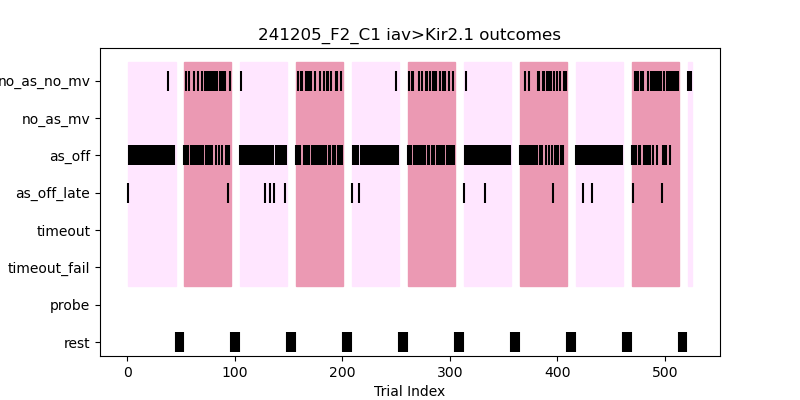

In [58]:
T.plot_outcomes()

In [57]:
plt.close()

In [18]:
for ocb in T_.op_cnd_blocks.unique():
    T_rows = T_[T_.op_cnd_blocks==ocb]
    tr_max = T_rows.index.max()
    tr_min = T_rows.index.min()
    print(f'[{tr_min}, {tr_max}]')

[1, 44]
[53, 96]
[105, 148]
[157, 200]
[209, 252]
[261, 304]
[313, 356]
[365, 408]
[417, 460]
[469, 512]
[521, 524]


In [18]:
T_rows = T

0